In [ ]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import seaborn as sns
import folium
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import paths_cpt 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc, RocCurveDisplay
import os

print(os.getcwd())
seed = 22

df = pd.read_parquet(paths_cpt.PATH_TO_PARQUET)
print(df.shape)
df.head()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
c:\Users\volte\OneDrive\Dokumente\usecase_cpt\CPT_usecase\modeling
(1222711, 19)


,sondering_id,index,pkey_sondering,sondeernummer,x,y,start_sondering_mtaw,diepte_sondering_tot,diepte,diepte_mtaw,qc,fs,qtn,rf,fr,icn,sbt,ksbt,lithostrat_id
0,314,2593,https://www.dov.vlaanderen.be/data/sondering/1...,GEO-97/127-S2,153278.2,181734.6,15.26,25.4,1.6,13.66,1.17,0.035,35.894004,2.991453,3.058371,2.564340,5.0,1.434000e-07,Quartair
1,314,2594,https://www.dov.vlaanderen.be/data/sondering/1...,GEO-97/127-S2,153278.2,181734.6,15.26,25.4,1.7,13.56,1.57,0.033,42.562319,2.101911,2.138968,2.406724,5.0,4.321000e-07,Quartair
2,314,2595,https://www.dov.vlaanderen.be/data/sondering/1...,GEO-97/127-S2,153278.2,181734.6,15.26,25.4,1.8,13.46,1.43,0.036,38.536991,2.517483,2.569226,2.491219,5.0,2.392000e-07,Quartair
3,314,2596,https://www.dov.vlaanderen.be/data/sondering/1...,GEO-97/127-S2,153278.2,181734.6,15.26,25.4,1.9,13.36,0.50,0.024,15.678501,4.800000,5.111166,2.982185,3.0,7.700000e-09,Quartair
4,314,2597,https://www.dov.vlaanderen.be/data/sondering/1...,GEO-97/127-S2,153278.2,181734.6,15.26,25.4,2.0,13.26,1.33,0.023,33.203119,1.729323,1.772110,2.440158,5.0,3.419000e-07,Quartair


In [22]:
print("Unique lithostrats : ", df.lithostrat_id.unique())
print("Count NAs : ", df.isna().sum())

Unique lithostrats :  ['Quartair' 'Mont_Panisel' 'Aalbeke' None 'Mons_en_Pevele'
 'Quartair + Mont_Panisel' 'Gentbrugge' 'Egem' 'Maldegem' 'Brussel'
 'Onbekend' 'Ursel' 'Asse' 'Wemmel' 'Lede' 'Bolderberg' 'Tielt'
 'Merelbeke' 'Kwatrecht' 'Antropogeen' 'Vlierzele'
 'Schelde Groep + Mons_en_Pevele' 'Veldwezelt en Gembloux' 'Diest'
 'Orchies' 'Tertiair' 'Egemkapel' 'Sint_Huibrechts_Hern'
 'Quartair_Holoceen' 'Onbekend + Mont_Panisel']
Count NAs :  sondering_id                  0
index                         0
pkey_sondering           469344
sondeernummer                 0
x                             0
y                             0
start_sondering_mtaw          0
diepte_sondering_tot          0
diepte                        0
diepte_mtaw                   0
qc                            0
fs                            0
qtn                           2
rf                            0
fr                            0
icn                         762
sbt                         762
ksbt   

In [23]:
target_set = df[(df["lithostrat_id"].isna()) | (df["lithostrat_id"]=="None") | df["lithostrat_id"].str.contains('Onbekend')]
train_set = df[~((df["lithostrat_id"].isna()) | (df["lithostrat_id"]=="None") | df["lithostrat_id"].str.contains('Onbekend'))]
print("rows in train and target are : ", train_set.shape[0], " ; ", target_set.shape[0], ",",\
       target_set.shape[0] + train_set.shape[0], " = ", df.shape[0])

rows in train and target are :  196012  ;  1026699 , 1222711  =  1222711


In [24]:
target_set.lithostrat_id.unique()
train_set.lithostrat_id.unique()

array(['Quartair', 'Mont_Panisel', 'Aalbeke', 'Mons_en_Pevele',
       'Quartair + Mont_Panisel', 'Gentbrugge', 'Egem', 'Maldegem',
       'Brussel', 'Ursel', 'Asse', 'Wemmel', 'Lede', 'Bolderberg',
       'Tielt', 'Merelbeke', 'Kwatrecht', 'Antropogeen', 'Vlierzele',
       'Schelde Groep + Mons_en_Pevele', 'Veldwezelt en Gembloux',
       'Diest', 'Orchies', 'Tertiair', 'Egemkapel',
       'Sint_Huibrechts_Hern', 'Quartair_Holoceen'], dtype=object)

In [25]:
train_set.dropna(inplace=True)
y = train_set.lithostrat_id
X = train_set.drop(columns = ["lithostrat_id"])
X.drop(columns=["pkey_sondering", "sondeernummer", "x", "y", "sondering_id", "index"], inplace=True)
X.head()

C:\Users\volte\AppData\Local\Temp\ipykernel_35384\1033929061.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set.dropna(inplace=True)


,start_sondering_mtaw,diepte_sondering_tot,diepte,diepte_mtaw,qc,fs,qtn,rf,fr,icn,sbt,ksbt
0,15.26,25.4,1.6,13.66,1.17,0.035,35.894004,2.991453,3.058371,2.564340,5.0,1.434000e-07
1,15.26,25.4,1.7,13.56,1.57,0.033,42.562319,2.101911,2.138968,2.406724,5.0,4.321000e-07
2,15.26,25.4,1.8,13.46,1.43,0.036,38.536991,2.517483,2.569226,2.491219,5.0,2.392000e-07
3,15.26,25.4,1.9,13.36,0.50,0.024,15.678501,4.800000,5.111166,2.982185,3.0,7.700000e-09
4,15.26,25.4,2.0,13.26,1.33,0.023,33.203119,1.729323,1.772110,2.440158,5.0,3.419000e-07


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(y_test.head())

(111933, 12) (37312, 12) (111933,) (37312,)
515035           Brussel
534331           Brussel
467323              Lede
20863     Mons_en_Pevele
213930           Brussel
Name: lithostrat_id, dtype: object


In [7]:
#One vs rest, one model per category
model1 = LogisticRegression(random_state=seed, multi_class="ovr", class_weight="balanced").fit(X_train, y_train)

c:\Users\volte\Documents\gcp_practice\GCP_functions_and_scripts\tf_on_gcp_experiments\.env\lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\volte\Documents\gcp_practice\GCP_functions_and_scripts\tf_on_gcp_experiments\.env\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_

In [8]:
y_pred = model1.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Overall accuracy:", accuracy)

classes = y_test.unique()
matrix = confusion_matrix(y_test, y_pred, labels=classes)

#This is apparently how you get per calss accuracy: 
# https://stackoverflow.com/questions/39770376/scikit-learn-get-accuracy-scores-for-each-class
granular_acc  = matrix.diagonal()/matrix.sum(axis=1)

df_summary = pd.DataFrame({
    "class": classes,
    "accuracy": granular_acc
})
print("avg accuracy : ", df_summary.accuracy.mean())
print("Individual accuracies : ")
df_summary

Overall accuracy: 0.4193021012006861
avg accuracy :  0.5039778837105164
Individual accuracies : 


,class,accuracy
0,Brussel,0.425615
1,Lede,0.430713
2,Mons_en_Pevele,0.211250
3,Quartair,0.315120
4,Sint_Huibrechts_Hern,0.653395
5,Aalbeke,0.511290
6,Wemmel,0.470361
7,Diest,0.602101
8,Mont_Panisel,0.492754
9,Quartair_Holoceen,0.280172


In [9]:
print(classification_report(y_test, y_pred))

                                precision    recall  f1-score   support

                       Aalbeke       0.50      0.51      0.51       620
                   Antropogeen       0.02      0.10      0.04       273
                          Asse       0.39      0.45      0.42      1234
                    Bolderberg       0.16      0.18      0.17       525
                       Brussel       0.65      0.43      0.52      6137
                         Diest       0.51      0.60      0.55      2189
                          Egem       0.01      0.67      0.01         6
                     Egemkapel       0.04      0.92      0.08        64
                    Gentbrugge       0.16      0.77      0.27       196
                     Kwatrecht       0.34      0.38      0.36       696
                          Lede       0.62      0.43      0.51      4936
                      Maldegem       0.06      0.36      0.10       242
                     Merelbeke       0.13      0.72      0.23  

## Adjusting for multicollinearity and VIF as verified in R

In [10]:

selected_vars = ['diepte', 'fs', 'qtn', 'fr', 'icn', 'sbt', 'ksbt']
X_train_selected = X_train[selected_vars]
X_test_selected = X_test[selected_vars]
model2 = LogisticRegression(random_state=seed, class_weight="balanced").fit(X_train_selected, y_train)

c:\Users\volte\Documents\gcp_practice\GCP_functions_and_scripts\tf_on_gcp_experiments\.env\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [11]:
y_pred = model2.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)
print("Overall accuracy:", accuracy)

classes = y_test.unique()
matrix = confusion_matrix(y_test, y_pred, labels=classes)

#This is apparently how you get per calss accuracy: 
# https://stackoverflow.com/questions/39770376/scikit-learn-get-accuracy-scores-for-each-class
granular_acc  = matrix.diagonal()/matrix.sum(axis=1)

df_summary = pd.DataFrame({
    "class": classes,
    "accuracy": granular_acc
})

print("avg accuracy : ", df_summary.accuracy.mean())
print("Individual accuracies : ")
df_summary

Overall accuracy: 0.18428387650085765
avg accuracy :  0.31608059866175325
Individual accuracies : 


,class,accuracy
0,Brussel,0.148444
1,Lede,0.091167
2,Mons_en_Pevele,0.342500
3,Quartair,0.061051
4,Sint_Huibrechts_Hern,0.015824
5,Aalbeke,0.551613
6,Wemmel,0.496993
7,Diest,0.227958
8,Mont_Panisel,0.432913
9,Quartair_Holoceen,0.655172


In [12]:
print(classification_report(y_test, y_pred))

                                precision    recall  f1-score   support

                       Aalbeke       0.36      0.55      0.44       620
                   Antropogeen       0.04      0.47      0.07       273
                          Asse       0.51      0.29      0.37      1234
                    Bolderberg       0.04      0.05      0.05       525
                       Brussel       0.46      0.15      0.22      6137
                         Diest       0.44      0.23      0.30      2189
                          Egem       0.00      0.17      0.00         6
                     Egemkapel       0.13      0.80      0.22        64
                    Gentbrugge       0.03      0.12      0.05       196
                     Kwatrecht       0.27      0.20      0.23       696
                          Lede       0.52      0.09      0.16      4936
                      Maldegem       0.04      0.07      0.05       242
                     Merelbeke       0.03      0.83      0.06  

## Random forest approach for nonlinear model

In [13]:
from sklearn.ensemble import RandomForestClassifier

model3 = RandomForestClassifier(
    n_estimators=200,
    random_state=seed,
    class_weight='balanced'
)
features = ['diepte',
       'qc', 'fs', 'qtn', 'rf', 'fr', 'icn', 'sbt', 'ksbt']
X_train = X_train[features]
X_test = X_test[features]

model3.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [14]:
X_train.head()

,diepte,qc,fs,qtn,rf,fr,icn,sbt,ksbt
467173,18.17,14.278,0.440,97.729230,3.081664,3.155658,2.268391,5.0,1.137900e-06
421605,19.70,15.858,0.568,84.430202,3.581788,3.673696,2.359871,5.0,5.998000e-07
392027,6.11,8.337,0.095,133.956790,1.139499,1.153761,1.856762,6.0,2.029750e-05
26745,19.25,6.390,0.180,37.635190,2.816901,2.983814,2.541855,5.0,1.678000e-07
294340,7.58,0.684,0.038,10.383701,5.555556,6.833470,3.200303,3.0,1.700000e-09


In [15]:
y_pred = model3.predict(X_test)

In [16]:
y_pred = model3.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Overall accuracy:", accuracy)

classes = y_test.unique()
matrix = confusion_matrix(y_test, y_pred, labels=classes)

#This is apparently how you get per calss accuracy: 
# https://stackoverflow.com/questions/39770376/scikit-learn-get-accuracy-scores-for-each-class
granular_acc  = matrix.diagonal()/matrix.sum(axis=1)

df_summary = pd.DataFrame({
    "class": classes,
    "accuracy": granular_acc
})

print("avg accuracy : ", df_summary.accuracy.mean())
print("Individual accuracies : ")
df_summary

Overall accuracy: 0.8130896226415094
avg accuracy :  0.6023853974836092
Individual accuracies : 


,class,accuracy
0,Brussel,0.793221
1,Lede,0.857374
2,Mons_en_Pevele,0.594375
3,Quartair,0.904823
4,Sint_Huibrechts_Hern,0.832057
5,Aalbeke,0.809677
6,Wemmel,0.792955
7,Diest,0.899041
8,Mont_Panisel,0.764376
9,Quartair_Holoceen,0.581897


In [17]:
print(classification_report(y_test, y_pred))

c:\Users\volte\Documents\gcp_practice\GCP_functions_and_scripts\tf_on_gcp_experiments\.env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\volte\Documents\gcp_practice\GCP_functions_and_scripts\tf_on_gcp_experiments\.env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


                                precision    recall  f1-score   support

                       Aalbeke       0.82      0.81      0.81       620
                   Antropogeen       0.73      0.33      0.45       273
                          Asse       0.72      0.84      0.78      1234
                    Bolderberg       0.77      0.42      0.54       525
                       Brussel       0.81      0.79      0.80      6137
                         Diest       0.85      0.90      0.88      2189
                          Egem       0.00      0.00      0.00         6
                     Egemkapel       0.98      0.95      0.97        64
                    Gentbrugge       0.72      0.43      0.54       196
                     Kwatrecht       0.76      0.80      0.78       696
                          Lede       0.83      0.86      0.85      4936
                      Maldegem       0.80      0.55      0.65       242
                     Merelbeke       0.85      0.85      0.85  

c:\Users\volte\Documents\gcp_practice\GCP_functions_and_scripts\tf_on_gcp_experiments\.env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [18]:
print(y_pred)

['Brussel' 'Brussel' 'Lede' ... 'Mons_en_Pevele' 'Ursel' 'Brussel']


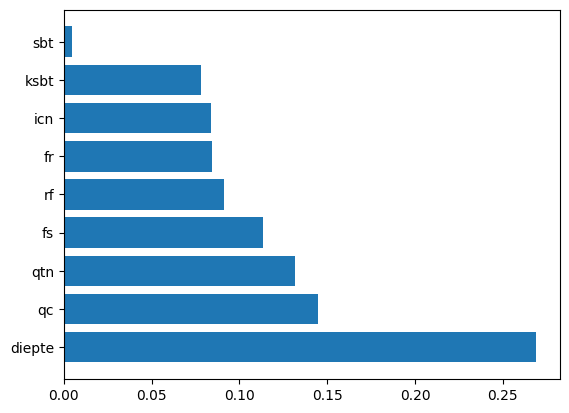

In [19]:
import matplotlib.pyplot as plt
import eli5
from eli5.sklearn import PermutationImportance
from eli5 import show_prediction, show_weights


importances = model3.feature_importances_
features = X_train.columns

summary_df = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

plt.barh(summary_df['feature'], summary_df['importance'])

plt.show()

In [20]:
#link: https://stats.stackexchange.com/questions/555949/how-to-interpret-the-feature-importances-for-eli5-show-weights-for-regressio
#eli5 docs: https://eli5.readthedocs.io/en/latest/autodocs/eli5.html
perm = PermutationImportance(model3, n_iter=10, random_state=seed)
perm.fit(X_test, y_test)

eli5.show_weights(perm, feature_names=X_test.columns.tolist())

KeyboardInterrupt: 

In [ ]:
import pickle

with open('rf_model_export.pkl', 'wb') as f:
    pickle.dump(model3, f)

## Conclusions:

The best model is a nonlinear one. There is plenty of multicollinearity between the depth measurements for a linear model such as the logistic one, but for the RF these are some of the most important metrics for predicting the class row by row. The most important features are related to height above sea level, interestingly.

In [ ]:
df.columns

Index(['sondering_id', 'index', 'pkey_sondering', 'sondeernummer', 'x', 'y',
       'start_sondering_mtaw', 'diepte_sondering_tot', 'diepte', 'diepte_mtaw',
       'qc', 'fs', 'qtn', 'rf', 'fr', 'icn', 'sbt', 'ksbt', 'lithostrat_id'],
      dtype='object')

In [28]:
import json

drillings = df.sondering_id.unique()
dict_sequences = {}
for drill in drillings:
    subdf = df[df["sondering_id"]==drill]
    previous = None
    for i, row in subdf.iterrows():
        current = row["lithostrat_id"]
        if current not in dict_sequences.keys():
            dict_sequences[current] = []
        if previous != None and current != previous and current not in dict_sequences[previous]:
            dict_sequences[previous].append(current)
        previous = current
print(dict_sequences)

with open("possible_sequences.txt", "w") as f:
    json.dump([dict_sequences], f, indent=4)


{'Quartair': ['Mont_Panisel', 'Gentbrugge', 'Maldegem', None, 'Brussel', 'Aalbeke', 'Tielt', 'Merelbeke', 'Kwatrecht', 'Mons_en_Pevele', 'Lede', 'Ursel', 'Vlierzele', 'Wemmel', 'Schelde Groep + Mons_en_Pevele', 'Diest', 'Bolderberg', 'Tertiair', 'Asse', 'Sint_Huibrechts_Hern'], 'Mont_Panisel': ['Aalbeke'], 'Aalbeke': [None, 'Mons_en_Pevele', 'Quartair + Mont_Panisel'], None: [], 'Mons_en_Pevele': ['Orchies'], 'Quartair + Mont_Panisel': ['Aalbeke', None], 'Gentbrugge': ['Egem', None], 'Egem': [], 'Maldegem': ['Lede'], 'Brussel': [None, 'Mont_Panisel', 'Aalbeke'], 'Onbekend': ['Ursel', 'Asse', 'Bolderberg', 'Lede', 'Kwatrecht', 'Merelbeke', 'Diest', 'Wemmel', 'Aalbeke', 'Brussel', None, 'Veldwezelt en Gembloux', 'Sint_Huibrechts_Hern'], 'Ursel': ['Asse'], 'Asse': ['Wemmel'], 'Wemmel': ['Lede', None], 'Lede': ['Kwatrecht', 'Merelbeke', 'Brussel', 'Egemkapel', None, 'Mont_Panisel'], 'Bolderberg': ['Ursel'], 'Tielt': [], 'Merelbeke': ['Kwatrecht', None], 'Kwatrecht': ['Mont_Panisel', 'Merel

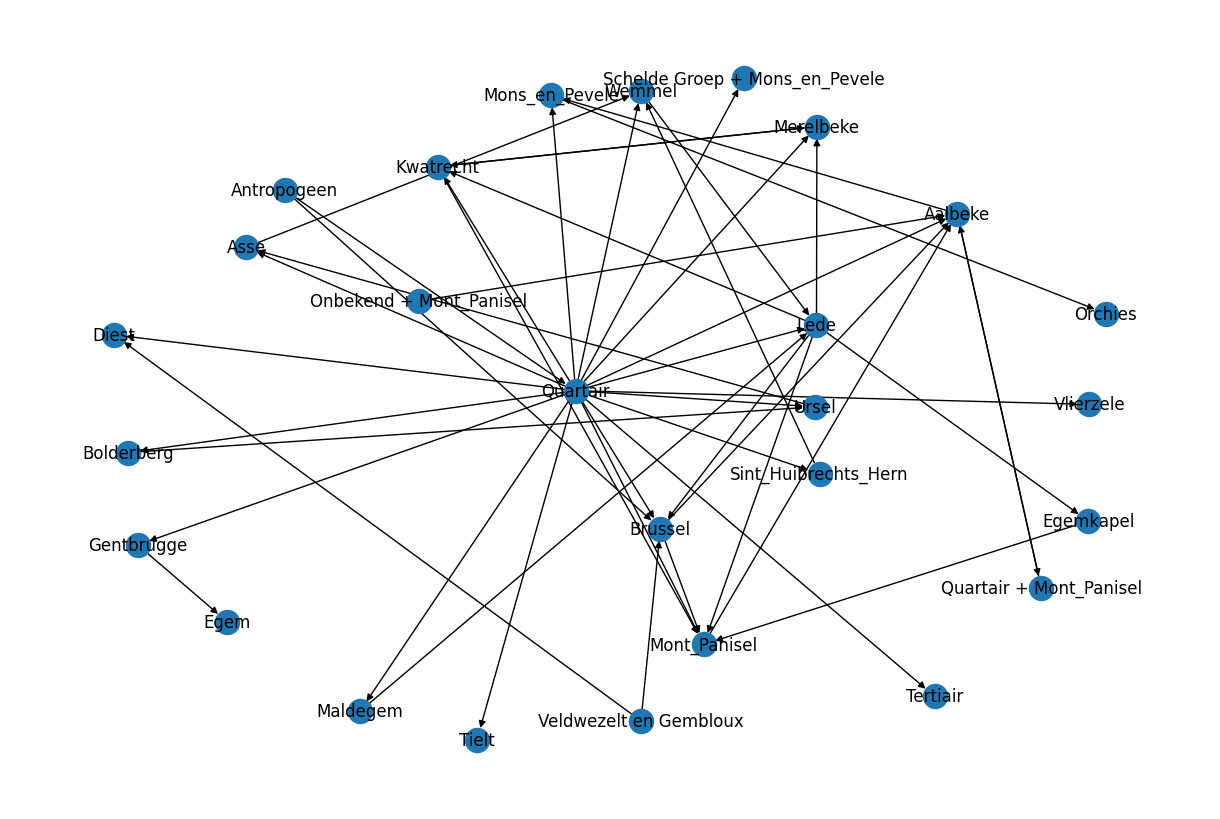

In [33]:
#%pip install networkx
import networkx as nx

G = nx.DiGraph()

for node, neighbors in dict_sequences.items():
    for neighbor in neighbors:
        try:
            if node != "Onbekend" and neighbor != "Onbekend":
                G.add_edge(node, neighbor)
        except ValueError:
            pass

plt.figure(figsize=(12, 8))
#plt.figure()
pos = nx.spring_layout(G, k=1.5)
nx.draw(G, pos, with_labels=True, arrows=True)
plt.savefig("segment_order.png", dpi=300, bbox_inches='tight')
plt.show()

## Final version of the sequence of the layers of interest

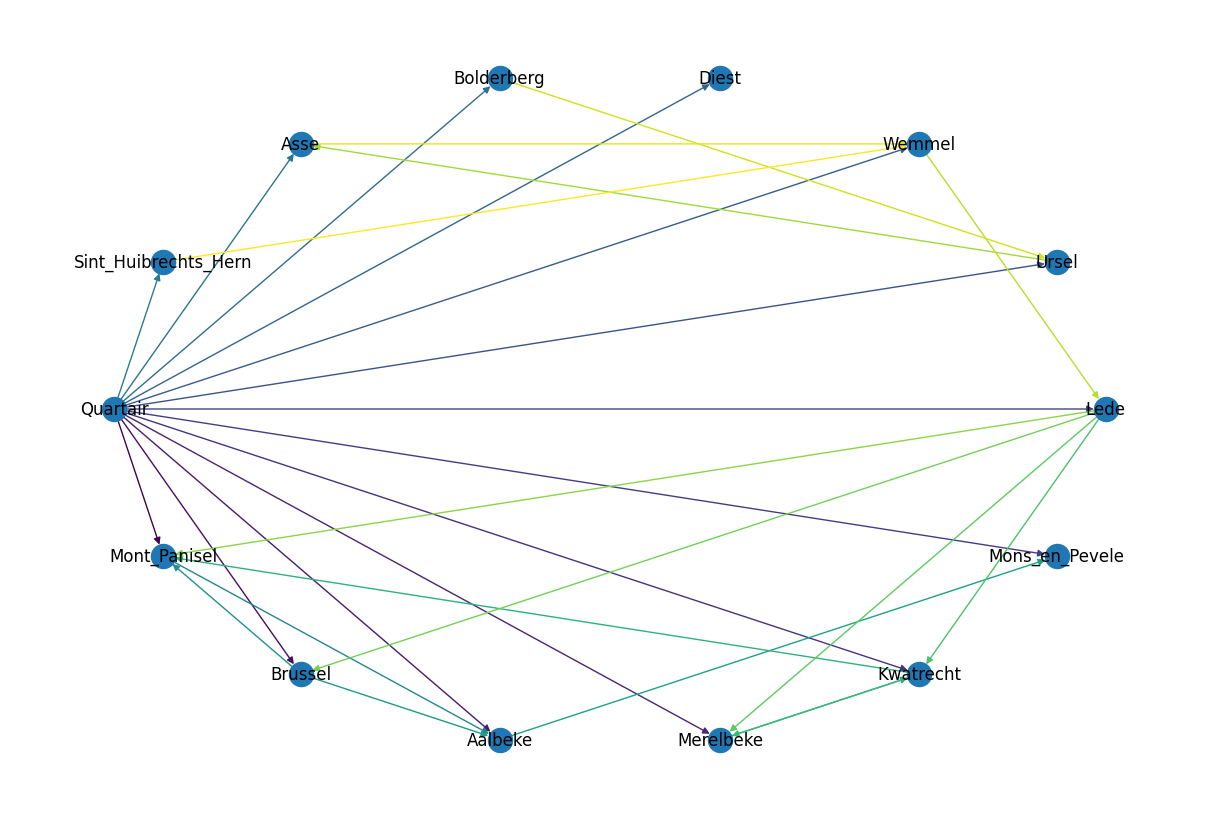

In [41]:
import networkx as nx

segments_oi = [
"Quartair",
"Diest",
"Bolderberg",
"Sint_Huibrechts_Hern",
"Ursel",
"Asse",
"Wemmel",
"Lede",
"Brussel",
"Merelbeke",
"Kwatrecht",
"Mont_Panisel",
"Aalbeke",
"Mons_en_Pevele",
]


G = nx.DiGraph()

for node, neighbors in dict_sequences.items():
    for neighbor in neighbors:
        try:
            if node in segments_oi and neighbor in segments_oi:
                G.add_edge(node, neighbor)
        except ValueError:
            pass

M = G.number_of_edges()
edge_colors = range(2, M + 2)
plt.figure(figsize=(12, 8))
#plt.figure()
pos = nx.shell_layout(G, scale=3)
nx.draw(G, pos, edge_color=edge_colors, with_labels=True)
plt.savefig("segment_order_restricted.png", dpi=300, bbox_inches='tight')
plt.show()

In [47]:
segments = df.lithostrat_id.unique()
dict_segments = {seg : [] for seg in segments}
dict_segments["x"] = []
dict_segments["y"] = []

for drill in drillings:
    subdf = df[df["sondering_id"]==drill]
    dict_segments["x"].append(subdf.x.unique()[0])
    dict_segments["y"].append(subdf.y.unique()[0])
    for seg in segments:
        if seg in subdf.lithostrat_id.unique():
            dict_segments[seg].append(1)
        else:
            dict_segments[seg].append(0)

df_segment_presence = pd.DataFrame(dict_segments)
df_segment_presence["drilling"] = drillings
df_segment_presence.head()
df_segment_presence.to_csv("Segment_presence_per_drilling.csv")

In [44]:
df_segment_presence.sum().sort_values()

Quartair_Holoceen                                    1
Tertiair                                             1
Orchies                                              1
Onbekend + Mont_Panisel                              1
Egemkapel                                            1
Vlierzele                                            1
Schelde Groep + Mons_en_Pevele                       1
Tielt                                                2
Egem                                                 2
Veldwezelt en Gembloux                               3
Gentbrugge                                           3
Quartair + Mont_Panisel                              3
Antropogeen                                          5
Diest                                                6
Maldegem                                             6
Bolderberg                                           7
Merelbeke                                           10
Sint_Huibrechts_Hern                                11
Ursel     

## Below a map representation of our layers of interest

In [ ]:
#%pip install folium
#%pip install geopandas




def pointlable(row):
    return ", ".join([seg for seg in segments_oi if row[seg] == 1])

df_segment_presence["label"] = df_segment_presence.apply(pointlable, axis=1)
df_seg_filtered = df_segment_presence[df_segment_presence["label"].str.len()> 0]
#print(df_segment_presence["label"])

gdf = gpd.GeoDataFrame(
    df_seg_filtered,
    geometry=gpd.points_from_xy(df_seg_filtered["x"], df_seg_filtered["y"]),
    crs="EPSG:31370"
)

gdf = gdf.to_crs("EPSG:4326")

df_seg_filtered["lon"] = gdf.geometry.x
df_seg_filtered["lat"] = gdf.geometry.y

m = folium.Map(location=[50.8, 4.3], zoom_start=10)

for _, row in df_seg_filtered.iterrows():
    jitterx = row["lat"] + np.random.uniform(-0.001, 0.001)
    jittery = row["lon"] + np.random.uniform(-0.001, 0.001)
    folium.CircleMarker(
        location=[jitterx, jittery],
        fill=True,
        radius = 3,
        popup=str(row["label"]),
    ).add_to(m)

folium.LayerControl().add_to(m)
m.save("points_and_layers.html")
m

C:\Users\volte\AppData\Local\Temp\ipykernel_35384\1758942272.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seg_filtered["lon"] = gdf.geometry.x
C:\Users\volte\AppData\Local\Temp\ipykernel_35384\1758942272.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seg_filtered["lat"] = gdf.geometry.y


In [ ]:
drillings = train_set.sondering_id.unique()
len(drillings) * (3/4)

drillings = drillings[0:159]

train = train_set[train_set.sondering_id.isin(drillings)]
test = train_set[~train_set.sondering_id.isin(drillings)]

print(df_segment_presence[df_segment_presence.drilling.isin(drillings)].sum().sort_values())
print(df_segment_presence[~df_segment_presence.drilling.isin(drillings)].sum().sort_values())


Quartair_Holoceen                      0
Onbekend + Mont_Panisel                0
Sint_Huibrechts_Hern                   0
Egemkapel                              1
Tertiair                               1
Orchies                                1
Veldwezelt en Gembloux                 1
Schelde Groep + Mons_en_Pevele         1
Vlierzele                              1
Quartair + Mont_Panisel                2
Egem                                   2
Tielt                                  2
Gentbrugge                             3
Antropogeen                            4
Merelbeke                              4
Bolderberg                             5
Maldegem                               6
Diest                                  6
Kwatrecht                             13
Ursel                                 18
Aalbeke                               19
None                                  20
Onbekend                              21
Asse                                  22
Mons_en_Pevele  

In [ ]:
X_train = train[['diepte_mtaw','diepte','qc', 'fs', 'qtn', 'rf', 'fr', 'icn', 'sbt', 'ksbt']]
y_train = train[['lithostrat_id']]
X_test = test[['diepte_mtaw', 'diepte','qc', 'fs', 'qtn', 'rf', 'fr', 'icn', 'sbt', 'ksbt']]
y_test = test['lithostrat_id']


In [ ]:
model4 = RandomForestClassifier(
    n_estimators=200,
    random_state=seed,
    class_weight='balanced'
)

model4.fit(X_train, y_train)

c:\Users\volte\Documents\gcp_practice\GCP_functions_and_scripts\tf_on_gcp_experiments\.env\lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
y_pred = model4.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Overall accuracy:", accuracy)

classes = y_test.unique()
matrix = confusion_matrix(y_test, y_pred, labels=classes)

#This is apparently how you get per calss accuracy: 
# https://stackoverflow.com/questions/39770376/scikit-learn-get-accuracy-scores-for-each-class
granular_acc  = matrix.diagonal()/matrix.sum(axis=1)

df_summary = pd.DataFrame({
    "class": classes,
    "accuracy": granular_acc
})

print("avg accuracy : ", df_summary.accuracy.mean())
print("Individual accuracies : ")
df_summary

Overall accuracy: 0.3111883791940978
avg accuracy :  0.3263190924679741
Individual accuracies : 


,class,accuracy
0,Lede,0.501280
1,Kwatrecht,0.793939
2,Mont_Panisel,0.329412
3,Quartair,0.923600
4,Asse,0.523364
5,Wemmel,0.444703
6,Bolderberg,0.000000
7,Ursel,0.628950
8,Brussel,0.167899
9,Mons_en_Pevele,0.255319


In [ ]:
X_train.columns

Index(['start_sondering_mtaw', 'diepte_sondering_tot', 'diepte', 'diepte_mtaw',
       'qc', 'fs', 'qtn', 'rf', 'fr', 'icn', 'sbt', 'ksbt'],
      dtype='object')

In [ ]:
#Trying out statsmodels library
import numpy as np

y_codes = pd.Categorical(y_train).codes
X_train_enc = sm.add_constant(X_train)

#Multinomial logit, slightly different than OvR
mnlogit = sm.MNLogit(y_codes, X_train_enc)
mnlogit_fit = mnlogit.fit()

c:\Users\volte\Documents\gcp_practice\GCP_functions_and_scripts\tf_on_gcp_experiments\.env\lib\site-packages\statsmodels\discrete\discrete_model.py:3027: RuntimeWarning: overflow encountered in exp
  eXB = np.column_stack((np.ones(len(X)), np.exp(X)))
c:\Users\volte\Documents\gcp_practice\GCP_functions_and_scripts\tf_on_gcp_experiments\.env\lib\site-packages\statsmodels\discrete\discrete_model.py:3028: RuntimeWarning: invalid value encountered in divide
  return eXB/eXB.sum(1)[:,None]


Optimization terminated successfully.
         Current function value: nan
         Iterations 3
